In [2]:
# import libraries

import os

import IPython.display as ipd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as skl
import sklearn.utils, sklearn.preprocessing, sklearn.decomposition, sklearn.svm
import librosa
import librosa.display

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import confusion_matrix, cohen_kappa_score, make_scorer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_predict

from xgboost import XGBClassifier, plot_importance

RSEED=42

In [3]:
# read data
df=pd.read_csv('/Users/annelahann/neue-fische/RiffRefine/data/data_with_target.csv')
df.head()


,Unnamed: 0,track_id,album_comments,album_date_created,album_favorites,album_id,album_listens,album_title,album_tracks,album_type,...,track_title_char_count,album_information_bin,artist_bio_bin,months_life,months,listens_month,bonus_listens,listens_incl_bonus,listens_bins,genre_pred
0,0,2,0,2008-11-26 01:44:45,4,1,6073,AWOL - A Way Of Life,7,Album,...,4,1,1,101,11,12.801980,0.0,1293.0,2,4
1,1,5,0,2008-11-26 01:44:45,4,1,6073,AWOL - A Way Of Life,7,Album,...,10,1,1,101,11,11.396040,0.0,1151.0,1,4
2,2,10,0,2008-11-26 01:45:08,4,6,47632,Constant Hitmaker,2,Album,...,7,0,1,101,11,496.386139,0.0,50135.0,4,1
3,3,140,1,2008-11-26 01:49:59,1,61,1300,The Blind Spot,1,Album,...,18,1,1,101,11,12.861386,0.0,1299.0,2,1
4,4,141,0,2008-11-26 01:49:57,1,60,1304,Every Man For Himself,2,Album,...,4,1,1,101,11,7.178218,0.0,725.0,1,1


In [4]:
#feature engineering
def limit_elements(lst):
    if len(lst) > 15:
        return 16
    else:
        return len(lst)
    
df['number_of_genres'] = df['track_genres'].apply(limit_elements)

df['number_of_genres_bins'] = pd.cut(df['number_of_genres'], bins=[0, 4, 8, 10, float('inf')], right=True)



In [5]:
# traget variable for xgboost

df['listens_bins']=df['listens_bins']-1
df['listens_bins'].value_counts()

listens_bins
1    2054
2    2053
3    1960
0    1933
Name: count, dtype: int64

In [6]:
# feature engineering

def categorize_license(license):
    if "Public Domain" in license or "CC0" in license:
        return 1  # allows everything
    elif "NoDerivatives" in license and "NonCommercial" in license:
        return 4  
    elif "NonCommercial" in license:
        return 3  
    elif "Share Alike" in license:
        return 2  
    else:
        return 1  
    
df['license_category'] = df['track_license'].apply(categorize_license)



In [7]:
# object into category

df['license_category'] = df['license_category'].astype('category')
df['track_genre_top'] = df['track_genre_top'].astype('category')
df['number_of_genres_bins'] = df['number_of_genres_bins'].astype('category')

In [8]:
# Define predictors and target variable

X = df[['track_genre_top','track_bit_rate','track_duration','album_information_bin','album_tracks','artist_bio_bin','track_title_char_count','track_number','license_category','other_website','soundcloud_website','number_of_genres_bins']]
y = df['listens_bins']
print(f"We have {X.shape[0]} observations in our dataset and {X.shape[1]} features")
print(f"Our target vector has also {y.shape[0]} values")


We have 8000 observations in our dataset and 12 features
Our target vector has also 8000 values


In [9]:
# Split into train and test set 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RSEED)
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)
pd.set_option('display.max_columns', 600)
X_train.info()

X_train shape: (6400, 12)
X_test shape: (1600, 12)
y_train shape: (6400,)
y_test shape: (1600,)
<class 'pandas.core.frame.DataFrame'>
Index: 6400 entries, 1467 to 7270
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   track_genre_top         6400 non-null   category
 1   track_bit_rate          6400 non-null   int64   
 2   track_duration          6400 non-null   int64   
 3   album_information_bin   6400 non-null   int64   
 4   album_tracks            6400 non-null   int64   
 5   artist_bio_bin          6400 non-null   int64   
 6   track_title_char_count  6400 non-null   int64   
 7   track_number            6400 non-null   int64   
 8   license_category        6400 non-null   category
 9   other_website           6400 non-null   bool    
 10  soundcloud_website      6400 non-null   bool    
 11  number_of_genres_bins   6400 non-null   category
dtypes: bool(2), category(3), int64(7)
memo

In [10]:
# Run and fit model (parameters already from grid search)

xgb = XGBClassifier(random_state=RSEED, tree_method="hist", enable_categorical=True, use_label_encoder=False,max_depth=15,gamma=1.0,learning_rate=0.2,n_estimators=60)
xgb.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=True, eval_metric=None, feature_types=None,
              gamma=1.0, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=15, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=60, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [11]:
# predict data with model

y_train_pred_xgb = xgb.predict(X_train)
y_test_pred_xgb = xgb.predict(X_test)

In [12]:
# Print % per class and Cohen's Kappa for Train data

conf_matrix= confusion_matrix(y_train, y_train_pred_xgb)
accurate_classes = sum([conf_matrix[i][i] for i in range(len(conf_matrix))])
off_by_one = sum([conf_matrix[i][j] if abs(i - j) == 1 else 0 for i in range(len(conf_matrix)) for j in range(len(conf_matrix))])
off_by_two = sum([conf_matrix[i][j] if abs(i - j) == 2 else 0 for i in range(len(conf_matrix)) for j in range(len(conf_matrix))])
off_by_three = sum([conf_matrix[i][j] if abs(i - j) == 3 else 0 for i in range(len(conf_matrix)) for j in range(len(conf_matrix))])

print((100*accurate_classes/conf_matrix.sum()).round(1))
print((100*off_by_one/conf_matrix.sum()).round(1))
print((100*off_by_two/conf_matrix.sum()).round(1))
print((100*off_by_three/conf_matrix.sum()).round(1))
print('--------------------------------')
print(cohen_kappa_score(y_train, y_train_pred_xgb,weights='linear').round(3))

82.7
13.2
3.3
0.8
--------------------------------
0.825


In [13]:
# Print % per class and Cohen's Kappa for Test data

conf_matrix= confusion_matrix(y_test, y_test_pred_xgb)
accurate_classes = sum([conf_matrix[i][i] for i in range(len(conf_matrix))])
off_by_one = sum([conf_matrix[i][j] if abs(i - j) == 1 else 0 for i in range(len(conf_matrix)) for j in range(len(conf_matrix))])
off_by_two = sum([conf_matrix[i][j] if abs(i - j) == 2 else 0 for i in range(len(conf_matrix)) for j in range(len(conf_matrix))])
off_by_three = sum([conf_matrix[i][j] if abs(i - j) == 3 else 0 for i in range(len(conf_matrix)) for j in range(len(conf_matrix))])
#off_by_four = sum([conf_matrix[i][j] if abs(i - j) == 4 else 0 for i in range(len(conf_matrix)) for j in range(len(conf_matrix))])

print((100*accurate_classes/conf_matrix.sum()).round(1))
print((100*off_by_one/conf_matrix.sum()).round(1))
print((100*off_by_two/conf_matrix.sum()).round(1))
print((100*off_by_three/conf_matrix.sum()).round(1))
#print((100*off_by_four/conf_matrix.sum()).round(1))
print('--------------------------------')
print(cohen_kappa_score(y_test, y_test_pred_xgb,weights='linear').round(3))

59.2
33.1
6.3
1.4
--------------------------------
0.604


In [14]:
# Join X_test, y_test and y predictions

y_test = pd.Series(y_test)
y_test_pred_xgb = pd.Series(y_test_pred_xgb)

X_test=pd.DataFrame(X_test)

X_test_reset = X_test.reset_index(drop=True)
y_test_reset = y_test.reset_index(drop=True)
y_test_pred_xgb_reset = y_test_pred_xgb.reset_index(drop=True)

X_test_preds = pd.concat([X_test_reset, y_test_reset, y_test_pred_xgb_reset], axis=1)
X_test_preds.columns = list(X_test_reset.columns) + ['y_test', 'y_test_pred_xgb']

X_test_preds

,track_genre_top,track_bit_rate,track_duration,album_information_bin,album_tracks,artist_bio_bin,track_title_char_count,track_number,license_category,other_website,soundcloud_website,number_of_genres_bins,y_test,y_test_pred_xgb
0,Pop,320000,209,1,12,0,9,4,2,True,False,"(0.0, 4.0]",3,0
1,Rock,256000,275,1,31,1,11,7,1,False,False,"(0.0, 4.0]",2,3
2,International,256000,255,1,32,1,11,2,4,True,False,"(0.0, 4.0]",2,0
3,Electronic,320000,265,1,9,1,14,7,3,True,False,"(4.0, 8.0]",3,3
4,Electronic,228446,494,1,19,1,27,18,3,False,True,"(10.0, inf]",3,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1595,Electronic,320000,320,1,11,0,16,4,3,True,False,"(4.0, 8.0]",2,3
1596,Instrumental,320000,201,1,8,1,19,5,1,True,False,"(8.0, 10.0]",3,3
1597,Experimental,320000,297,1,3,1,7,3,2,True,False,"(4.0, 8.0]",1,1
1598,Hip-Hop,320000,251,1,8,1,44,2,4,True,False,"(0.0, 4.0]",1,1


In [15]:
# Define variables for misclassification

X_test_preds['misclass'] = (X_test_preds['y_test'] != X_test_preds['y_test_pred_xgb']).astype(int)
X_test_preds['misclass_1'] = (abs(X_test_preds['y_test'] - X_test_preds['y_test_pred_xgb']) == 1).astype(int) #misclassed by one
X_test_preds['misclass_2'] = (abs(X_test_preds['y_test'] - X_test_preds['y_test_pred_xgb']) == 2).astype(int) #misclassed by two
X_test_preds['misclass_3'] = (abs(X_test_preds['y_test'] - X_test_preds['y_test_pred_xgb']) == 3).astype(int) #misclassed by three
X_test_preds['misclass_'] = X_test_preds['misclass']  #misclassed by n
X_test_preds.loc[X_test_preds['misclass_1'] == 1, 'misclass_'] = 1
X_test_preds.loc[X_test_preds['misclass_2'] == 1, 'misclass_'] = 2
X_test_preds.loc[X_test_preds['misclass_3'] == 1, 'misclass_'] = 3

# predicted better/worse than y_test
X_test_preds['misclass_bet'] = ((X_test_preds['y_test'] - X_test_preds['y_test_pred_xgb']) >= 1).astype(int)
X_test_preds['misclass_wor'] = ((X_test_preds['y_test'] - X_test_preds['y_test_pred_xgb']) <= -1).astype(int)
X_test_preds['misclass_bw'] = X_test_preds['misclass']
X_test_preds.loc[X_test_preds['misclass_bet'] == 1, 'misclass_bw'] = 1
X_test_preds.loc[X_test_preds['misclass_wor'] == 1, 'misclass_bw'] = 2

X_test_preds

,track_genre_top,track_bit_rate,track_duration,album_information_bin,album_tracks,artist_bio_bin,track_title_char_count,track_number,license_category,other_website,soundcloud_website,number_of_genres_bins,y_test,y_test_pred_xgb,misclass,misclass_1,misclass_2,misclass_3,misclass_,misclass_bet,misclass_wor,misclass_bw
0,Pop,320000,209,1,12,0,9,4,2,True,False,"(0.0, 4.0]",3,0,1,0,0,1,3,1,0,1
1,Rock,256000,275,1,31,1,11,7,1,False,False,"(0.0, 4.0]",2,3,1,1,0,0,1,0,1,2
2,International,256000,255,1,32,1,11,2,4,True,False,"(0.0, 4.0]",2,0,1,0,1,0,2,1,0,1
3,Electronic,320000,265,1,9,1,14,7,3,True,False,"(4.0, 8.0]",3,3,0,0,0,0,0,0,0,0
4,Electronic,228446,494,1,19,1,27,18,3,False,True,"(10.0, inf]",3,3,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1595,Electronic,320000,320,1,11,0,16,4,3,True,False,"(4.0, 8.0]",2,3,1,1,0,0,1,0,1,2
1596,Instrumental,320000,201,1,8,1,19,5,1,True,False,"(8.0, 10.0]",3,3,0,0,0,0,0,0,0,0
1597,Experimental,320000,297,1,3,1,7,3,2,True,False,"(4.0, 8.0]",1,1,0,0,0,0,0,0,0,0
1598,Hip-Hop,320000,251,1,8,1,44,2,4,True,False,"(0.0, 4.0]",1,1,0,0,0,0,0,0,0,0


In [16]:
X_test_preds['misclass_bw'].value_counts()
X_test_preds['misclass_'].value_counts()

misclass_
0    947
1    529
2    101
3     23
Name: count, dtype: int64

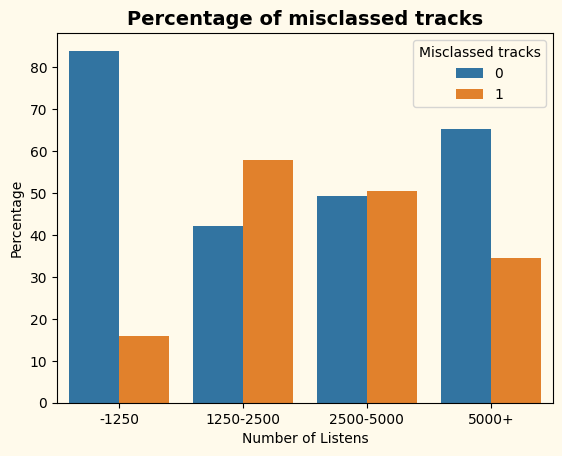

In [32]:
plt.rcParams['axes.facecolor'] = '#fffaeb'  # Background color
plt.rcParams['figure.facecolor'] = '#fffaeb'  # Background color
plt.rcParams['font.family'] = 'sans-serif'  # Font family

count_per_category = X_test_preds.groupby('y_test')['misclass'].value_counts(normalize=True).mul(100).rename('percentage').reset_index()
sns.barplot(data=count_per_category, x='y_test', y='percentage', hue='misclass')

plt.xticks([0, 1, 2, 3], ['-1250', '1250-2500', '2500-5000', '5000+'])
plt.xlabel('Number of Listens')  
plt.ylabel('Percentage')  
plt.title('Percentage of misclassed tracks',fontsize=14,fontweight='bold') 
plt.legend(title='Misclassed tracks')
plt.show()

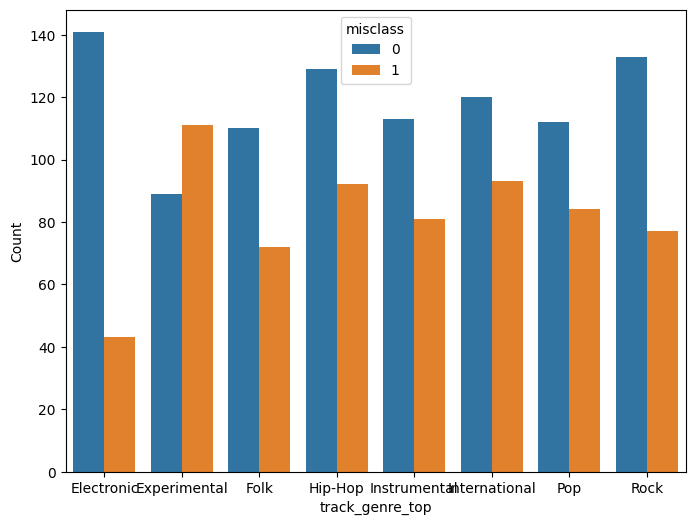

In [34]:
plt.figure(figsize=(8, 6))
sns.countplot(data=X_test_preds, x=X_test_preds['track_genre_top'], hue='misclass')
plt.ylabel('Count')
plt.show()

In [35]:
# Test of difference between misclassed 0/1 (MannWhitney for metric features)

from scipy import stats

columns_cat = ['track_genre_top','number_of_genres_bins','license_category','other_website','soundcloud_website','album_information_bin','artist_bio_bin']
columns_int = ['track_bit_rate','album_tracks','track_duration','track_title_char_count','track_number']

for column in columns_int:
    misclass_0 = X_test_preds[X_test_preds['misclass'] == 0][column]
    misclass_1 = X_test_preds[X_test_preds['misclass'] == 1][column]
    u_stat, p_value = stats.mannwhitneyu(misclass_0, misclass_1)
    print(column)
    print(f"Mann-Whitney-U-Test: p-value = {p_value}")



track_bit_rate
Mann-Whitney-U-Test: p-value = 0.1541096196513987
album_tracks
Mann-Whitney-U-Test: p-value = 0.4804087985127321
track_duration
Mann-Whitney-U-Test: p-value = 0.7893147765833626
track_title_char_count
Mann-Whitney-U-Test: p-value = 0.6025832239577296
track_number
Mann-Whitney-U-Test: p-value = 0.9636443197535621


In [36]:
# Test of difference between misclassed 0/1 (Chi2 for categorical features)

from scipy.stats import chi2_contingency

for column in X_test_preds.columns:
    if column in columns_cat:
        cross_tab = pd.crosstab(X_test_preds[column], X_test_preds['misclass'])
        chi2, p_value, _, _ = chi2_contingency(cross_tab)
        print(column)
        print(f"P-Wert: {p_value}")


track_genre_top
P-Wert: 2.2990631288005195e-07
album_information_bin
P-Wert: 0.6301535509396536
artist_bio_bin
P-Wert: 0.7321641398269946
license_category
P-Wert: 0.9343901339357127
other_website
P-Wert: 0.04068775178988285
soundcloud_website
P-Wert: 0.14873921621707667
number_of_genres_bins
P-Wert: 0.2104032180980293
